<img style = "float: left; margin: 30px 15px 15px 15px;" src = "https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width = "300" height = "500" /> 
    
    
### <font color = "navy"> Simulación de procesos financieros. <font> 

**Nombres:** Moises Flores Ortíz y Miriam Eunice Rosas Medellín.

**Fecha:** 5 de mayo del 2021.

**Expediente**: 722183 y 721278.
**Profesor:** Oscar David Jaramillo Zuluaga.

# Tarea 10: Clase 23
**Link al repositorio en Github**: https://github.com/Miriam1999/Tarea10_MFlores_MERosas

## Ejercicio 1
Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y periodo $T = 1$ año, cuyo precio es $\approx 7.04$. Realizar la simulación con base en la siguiente tabla:
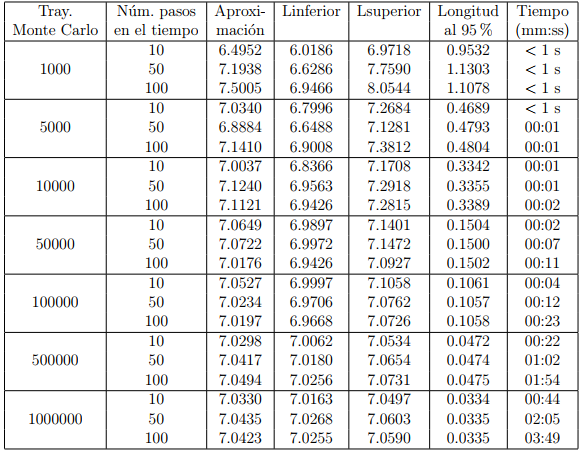

Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método. 
- Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una `DataFrame` de `Pandas` para reportar todos los resultados obtenidos **(70 puntos)**.
- Compare los resultados obtenidos con los resultados arrojados por la función `Riemann_approach` y concluya **(30 puntos)**.

### Solución de Moises

In [1]:
###importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import time
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 9)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

Primero se toma la función para generar precios por medio de simulación de monetecarlo  con el método de black and sholes.

In [2]:
###Función de simulación de precios-escenarios método B&S
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T,t


Para obtener la valución de la opción se utilizará el método del trapecio a diferencia del método de sumas de riemann que se hizo en clase por lo que se debe de usar el siguiente esquema de valuación:

$$\hat V_0^{(2)}= {e^{-rT} \over M} \sum_{j=1}^{M} \Bigg({h\over 2T} \sum_{i=0}^{N-1} S_{t_i}(2+rh+(W_{t_{i+1}}-W_{t_i})\sigma)-K \Bigg)_+$$

dónde

$$ h = \frac{T}{N}$$

A continuación, se hace una función que aplica el método de esquema de trapecios y lo hace tanto para opciones call como para opciones put pues se evaluará en ambos casos.

In [15]:
### Función donde se almacenan todos los resultados del método de esquema de trapecios
def Metodo_trapecio_valopt(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    tipo:"Tipo de opción: 'put' o 'call' recibe el string, default tipo call"=None):
    """ Está función devuelve la valuación, el limite inferior, superior y la longitud al 95% de confianza, además
    del tiempo que se tardó en correr todo el proceso para opciones de tipo put o call de acuerdo a la que requiera
    el usuario de acuerdo con el método de esquema de trapecios"""
    start = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    # En este caso se  define un h que se requiere para la fórmula del trapecio
    h = T/NbStep
    Average_t = np.cumsum(prices *
                          (2+r*h+np.random.randn(NbStep,NbTraj)*sigma))*h/(2*T)
    # Definimos el dataframe de strikes
    strike = K
    # Se valua la prima de acuerdo al tipo de opción: call o put
    if tipo == 'call':
        val_opt = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
    elif tipo == 'put':
        val_opt = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(strike - Average_t, 0).mean(axis=1)}, index=t)
    else:
        val_opt = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = val_opt.sem().Prima
    mean_est = val_opt.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    dif95 = i1[1] - i1[0]
    end = time.time()
    e = int(end - start)
    return np.array([val_opt.iloc[-1].Prima,i1[0],i1[1],dif95,
                     '{:02d}:{:02d}'.format((e % 3600 // 60), e % 60)])

In [16]:
### Función donde se almacenan todos los resultados del método de sumas de riemann
def Riemann_approach(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    tipo:"Tipo de opción: 'put' o 'call' recibe el string, default tipo call"=None):
    """ Está función devuelve la valuación, el limite inferior, superior y la longitud al 95% de confianza, además
    del tiempo que se tardó en correr todo el proceso para opciones de tipo put o call de acuerdo a la que requiera
    el usuario de acuerdo con el método de riemann"""
    start = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # # Se valua la prima de acuerdo al tipo de opción: call o put
    if tipo == 'call':
        val_opt = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
    elif tipo == 'put':
        val_opt = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(strike - Average_t, 0).mean(axis=1)}, index=t)
    else:
        val_opt = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = val_opt.sem().Prima
    mean_est = val_opt.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    dif95 = i1[1] - i1[0]
    end = time.time()
    e = int(end - start)
    return np.array([val_opt.iloc[-1].Prima,i1[0],i1[1],dif95,
                     '{:02d}:{:02d}'.format((e % 3600 // 60), e % 60)])

In [5]:
### Se definen los datos que provee el problema
S0 = 100 ###Strike price
r = 0.10 ###Tasa libre de riesgo
sigma = 0.2 
K = 100 ###Strike
T=1 ###Tiempo en años
NbTraj = [1000,5000,10000,50000,100000,500000,1000000] ###Número de trayectorias
NbStep = [10,50,100] ###Número de pasos

#### Tabla opción tipo Call método Esquema de Trapecios

In [17]:
###Se genera la simulación para el tipo call
call =  np.array(list(map(lambda N_traj:list(map(lambda N_step:
                                              Metodo_trapecio_valopt(K,r,S0,N_traj,N_step,sigma,T,'call'),NbStep)),NbTraj)))
call.shape

(7, 3, 5)

In [18]:
###Se genera la tabla de simulaciones para el tipo call
pd.set_option("display.max_rows", None, "display.max_columns", None)###Permite que se visualice toda la tabla en el jupyter
NbTrajidx =[i for i in NbTraj for _ in (0, 1, 2)]###Se genera un indice para las trayectorias
results = np.array(list(map(lambda i: call[:,:,i].flatten(),range(5))))### Se separan los resultados 
arrays = [NbTrajidx,NbStep*7,results[0],results[1],results[2],results[3],results[4]]###Se agregan los resultados a los indices
index = pd.MultiIndex.from_arrays(arrays, names=('Tray. Monte Carlo', 'Núm. pasos en el tiempo','Aproximación','Linferior'
                                                ,'Lsuperior','Longitud al 95%','Tiempo (mm::ss)'))###Se genera el multiIndex
pd.DataFrame(index=index)###Se convierte a DataFrame el MultiIndex

Empty DataFrame
Columns: []
Index: [(1000, 10, 6.801885028770498, 5.467428229678058, 8.136341827862939, 2.668913598184881, 00:00), (1000, 50, 6.752725831710719, 6.357631583633465, 7.147820079787973, 0.7901884961545083, 00:00), (1000, 100, 7.245575364816604, 6.959795187123572, 7.531355542509636, 0.5715603553860635, 00:00), (5000, 10, 6.928716720773903, 5.569250771010556, 8.288182670537251, 2.7189318995266953, 00:00), (5000, 50, 7.099329819784375, 6.678540392149041, 7.520119247419708, 0.8415788552706669, 00:00), (5000, 100, 6.893180954477299, 6.620997429494945, 7.165364479459653, 0.5443670499647073, 00:00), (10000, 10, 6.94366413862226, 5.580423313751041, 8.30690496349348, 2.726481649742439, 00:00), (10000, 50, 7.160849874126774, 6.7363074236491975, 7.585392324604351, 0.8490849009551535, 00:00), (10000, 100, 7.092852739364945, 6.812942727956193, 7.372762750773697, 0.5598200228175045, 00:00), (50000, 10, 6.917945683824027, 5.560761104327506, 8.275130263320548, 2.7143691589930423, 00:00), (50000, 50, 6.998571239446457, 6.5852553340016025, 7.411887144891312, 0.8266318108897099, 00:00), (50000, 100, 7.053693099877251, 6.77577342946817, 7.331612770286332, 0.5558393408181619, 00:00), (100000, 10, 6.9508177554265345, 5.587332331864369, 8.3143031789887, 2.7269708471243312, 00:00), (100000, 50, 6.980144622764946, 6.568145667700086, 7.392143577829807, 0.8239979101297212, 00:00), (100000, 100, 7.038699659084091, 6.761917669159832, 7.315481649008349, 0.5535639798485175, 00:01), (500000, 10, 6.919908270614996, 5.562699889997541, 8.27711665123245, 2.7144167612349097, 00:01), (500000, 50, 6.990357855250049, 6.577814050360696, 7.402901660139402, 0.8250876097787057, 00:03), (500000, 100, 7.028470967580172, 6.7519955079170435, 7.3049464272433005, 0.552950919326257, 00:06), (1000000, 10, 6.8943919973559815, 5.542315240863106, 8.246468753848857, 2.7041535129857515, 00:02), (1000000, 50, 7.002103849499741, 6.58882329905992, 7.415384399939562, 0.8265611008796423, 00:06), (1000000, 100, 7.032559462844573, 6.755922323036151, 7.309196602652996, 0.5532742796168453, 00:13)]

#### Tabla opción tipo Call método Riemann

In [8]:
###Se genera la simulación para el tipo call
call =  np.array(list(map(lambda N_traj:list(map(lambda N_step:
                                              Riemann_approach(K,r,S0,N_traj,N_step,sigma,T,'call'),NbStep)),NbTraj)))
call.shape

(7, 3, 5)

In [9]:
###Se genera la tabla de simulaciones para el tipo call
pd.set_option("display.max_rows", None, "display.max_columns", None)###Permite que se visualice toda la tabla en el jupyter
NbTrajidx =[i for i in NbTraj for _ in (0, 1, 2)]###Se genera un indice para las trayectorias
results = np.array(list(map(lambda i: call[:,:,i].flatten(),range(5))))### Se separan los resultados 
arrays = [NbTrajidx,NbStep*7,results[0],results[1],results[2],results[3],results[4]]###Se agregan los resultados a los indices
index = pd.MultiIndex.from_arrays(arrays, names=('Tray. Monte Carlo', 'Núm. pasos en el tiempo','Aproximación','Linferior'
                                                ,'Lsuperior','Longitud al 95%','Tiempo (mm::ss)'))###Se genera el multiIndex
pd.DataFrame(index=index)###Se convierte a DataFrame el MultiIndex

Empty DataFrame
Columns: []
Index: [(1000, 10, 6.529323219811123, 5.23002355799828, 7.828622881623966, 2.5985993236256864, 00:00:00), (1000, 50, 6.814981514671595, 6.305513627255776, 7.324449402087414, 1.0189357748316379, 00:00:00), (1000, 100, 6.560589958043716, 6.234247571728046, 6.886932344359385, 0.6526847726313392, 00:00:00), (5000, 10, 6.47285420930326, 5.1861052249867825, 7.759603193619737, 2.573497968632955, 00:00:00), (5000, 50, 6.989774038763142, 6.464785924715096, 7.514762152811188, 1.0499762280960923, 00:00:00), (5000, 100, 6.887981011323461, 6.535657840183499, 7.240304182463423, 0.7046463422799238, 00:00:00), (10000, 10, 6.422636416166436, 5.145362538424437, 7.699910293908435, 2.5545477554839984, 00:00:00), (10000, 50, 6.851048868452756, 6.339623948476016, 7.362473788429496, 1.02284983995348, 00:00:00), (10000, 100, 7.069407222031639, 6.7054786247133125, 7.433335819349966, 0.7278571946366537, 00:00:00), (50000, 10, 6.4118707834745114, 5.14028875868105, 7.6834528082679725, 2.543164049586922, 00:00:00), (50000, 50, 6.937931250874702, 6.419309732338362, 7.456552769411043, 1.037243037072681, 00:00:00), (50000, 100, 7.017091284291673, 6.654035223497515, 7.38014734508583, 0.7261121215883151, 00:00:01), (100000, 10, 6.4136680415036444, 5.143456986436414, 7.683879096570875, 2.540422110134461, 00:00:01), (100000, 50, 6.905657956816879, 6.389651428020874, 7.421664485612884, 1.0320130575920103, 00:00:02), (100000, 100, 6.951639532090482, 6.593245408908231, 7.310033655272733, 0.7167882463645014, 00:00:02), (500000, 10, 6.421052004614126, 5.147823911174806, 7.694280098053447, 2.5464561868786415, 00:00:08), (500000, 50, 6.913910520835504, 6.397887250208971, 7.429933791462037, 1.0320465412530666, 00:00:11), (500000, 100, 6.982538148093532, 6.622845950432033, 7.342230345755031, 0.7193843953229972, 00:00:14), (1000000, 10, 6.438336743961303, 5.161288048368913, 7.7153854395536925, 2.5540973911847793, 00:00:16), (1000000, 50, 6.912835306361753, 6.3970576968644135, 7.428612915859093, 1.0315552189946793, 00:00:19), (1000000, 100, 6.973376444886172, 6.614124084390726, 7.332628805381619, 0.718504720990893, 00:00:27)]

#### Comparación

(Markdown)

#### Tabla opción tipo Put método Esquema de Trapecios

In [ ]:
###Se genera la simulación para el tipo put
put =  np.array(list(map(lambda N_traj:list(map(lambda N_step:
                                              Metodo_trapecio_valopt(K,r,S0,N_traj,N_step,sigma,T,'put'),NbStep)),NbTraj)))
put.shape

In [ ]:
###Se genera la tabla de simulaciones para el tipo put
pd.set_option("display.max_rows", None, "display.max_columns", None)###Permite que se visualice toda la tabla en el jupyter
NbTrajidx =[i for i in NbTraj for _ in (0, 1, 2)]###Se genera un indice para las trayectorias
results = np.array(list(map(lambda i: put[:,:,i].flatten(),range(5))))### Se separan los resultados 
arrays = [NbTrajidx,NbStep*7,results[0],results[1],results[2],results[3],results[4]]###Se agregan los resultados a los indices
index = pd.MultiIndex.from_arrays(arrays, names=('Tray. Monte Carlo', 'Núm. pasos en el tiempo','Aproximación','Linferior'
                                                ,'Lsuperior','Longitud al 95%','Tiempo (mm::ss)'))###Se genera el multiIndex
pd.DataFrame(index=index)###Se convierte a DataFrame el MultiIndex

#### Tabla opción tipo Put método Riemann

In [ ]:
###Se genera la simulación para el tipo put
put =  np.array(list(map(lambda N_traj:list(map(lambda N_step:
                                             Riemann_approach(K,r,S0,N_traj,N_step,sigma,T,'put'),NbStep)),NbTraj)))
put.shape

In [ ]:
###Se genera la tabla de simulaciones para el tipo put
pd.set_option("display.max_rows", None, "display.max_columns", None)###Permite que se visualice toda la tabla en el jupyter
NbTrajidx =[i for i in NbTraj for _ in (0, 1, 2)]###Se genera un indice para las trayectorias
results = np.array(list(map(lambda i: put[:,:,i].flatten(),range(5))))### Se separan los resultados 
arrays = [NbTrajidx,NbStep*7,results[0],results[1],results[2],results[3],results[4]]###Se agregan los resultados a los indices
index = pd.MultiIndex.from_arrays(arrays, names=('Tray. Monte Carlo', 'Núm. pasos en el tiempo','Aproximación','Linferior'
                                                ,'Lsuperior','Longitud al 95%','Tiempo (mm::ss)'))###Se genera el multiIndex
pd.DataFrame(index=index)###Se convierte a DataFrame el MultiIndex

#### Comparación

(markdown )

### Solución de Miriam

#### <font color = "blue"> Importación de librerías, construcción de funciones y definición de datos <font>

Hay que recordar las siguientes ecuaciones
> El precio del activo subyacente en un mercado de riesgo neutro es de la forma
$$S_t = S_0\exp{\Bigg(r - \frac{\sigma^2}{2}\Bigg) t + \sigma \beta_t}$$

> La aproximación con las Sumas de Riemann se calcula así
$$\hat V_0^{(1)} = {e^{-rT} \over M} \sum_{j = 1}^{M} \Bigg({1\over N} \sum_{i = 0}^{N-1} S_{t_i} - K \Bigg)_+$$

> Mientras que con el esquema de trapecios se calcula así
$$\hat V_0^{(2)} = {e^{-rT} \over M} \sum_{j = 1}^{M} \Bigg({h\over 2T} \sum_{i = 0}^{N-1} S_{t_i}(2 + rh + (W_{t_{i + 1}} - W_{t_i}) \sigma)- K \Bigg)_+$$
Donde $h = \frac{T}{N}$

In [130]:
# Importar los paquetes que se van a usar
import time
import numpy as np
import pandas as pd
import scipy.stats as st

# Función que resuelve la ecuación de Black-Scholes
def BSprices(mu: "tasa libre de riesgo", sigma: "desviación estándar de los rendimientos (volatilidad)", 
             S0: "precio inicial del activo subyacente", NbTraj: "cantidad de trayectorias a simular", 
             T: "tiempo para el cierre del contrato en años", NbStep: "número de pasos en el tiempo"):
    """Expresión de la solución de la ecuación de Black-Scholes: St = S0 * exp((r-sigma^2 / 2) * t + sigma * DeltaW)."""
    nu = mu - (sigma**2) / 2 # datos para la fórmula de St
    DeltaT = T / NbStep # particiones en el tiempo
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT * np.random.randn(NbTraj, NbStep - 1)
    increments = nu * DeltaT + sigma * DeltaW # se obtiene --> Ln St = Ln S0 + nu * DeltaT + sigma * DeltaW
    concat = np.concatenate((np.log(S0) * np.ones([NbTraj, 1]), increments), axis = 1)
    LogSt = np.cumsum(concat, axis = 1) # se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    St = np.exp(LogSt) # se obtienen los precios simulados para los NbStep o días fijados
    t = np.arange(0, NbStep) # vector con la cantidad de días simulados
    return St.T, t

# Función que calcula los rendimientos diarios
def calc_daily_ret(closes: "precios de cierre"):
    """Esta función calcula los rendimientos diarios de un activo variable a partir de sus precios de cierre diarios."""
    return np.log(closes / closes.shift(1)).iloc[1:]

# Función donde se almacenan todos los datos con el Esquema del Trapecio
def Trap_approach(K: "precio strike", r: "tasa libre de riesgo", S0: "precio inicial del activo subyacente", 
                  NbTraj: "cantidad de trayectorias a simular", NbStep: "número de pasos en el tiempo", 
                  sigma: "desviación estándar de los rendimientos (volatilidad)", 
                  T: "tiempo para el cierre del contrato en años", 
                  tipo: "string con el tipo de opción asiática 'call' o 'put'"):
    """Esta función calcula la aproximación por el Esquema del Trapecio a la valuación real de la opción."""
    tiempo_inicial = time.time() # tiempo inicial
    St, t = BSprices(r, sigma, S0, NbTraj, T, NbStep) # resolver la ecuación de Black-Scholes para obtener los precios
    prices = pd.DataFrame(St, index = t) # almacenar los precios en un DataFrame
    h = T / NbStep
    Average_t = np.cumsum(prices * (2 + r * h + np.random.randn(NbStep, NbTraj) * sigma)) * h / (2 * T) # precios promedio
    strike = K # definir el DataFrame de strikes
    if tipo == "call":
        # Calcular el call de la opción según la formula obtenida para Sumas de Riemann
        primas = pd.DataFrame({"Prima": np.exp(-r * T) * np.fmax(Average_t - strike, 0).mean(axis = 1)}, index = t)
    else:
        # Calcular el put de la opción según la fórmula obtenida para Sumas de Riemann
        primas = pd.DataFrame({"Prima": np.exp(-r * T) * np.fmax(strike - Average_t, 0).mean(axis = 1)}, index = t)
    confianza = 0.95 # cálculo del intervalo de confianza con un nivel de confianza del 95%
    sigma_est = primas.sem().Prima # desviación estándar de las primas
    mean_est = primas.iloc[-1].Prima # media de las primas
    i = st.norm.interval(confianza, loc = mean_est, scale = sigma_est) # intervalo de confianza
    long_int = i[1] - i[0] # longitud del intervalo de confianza
    tiempo_fin = time.time() # tiempo final
    tiempo = int(tiempo_fin - tiempo_inicial) # tiempo en correr
    return ["%.4f" % round(primas.iloc[-1].Prima, 4), "%.4f" % round(i[0], 4), "%.4f" % round(i[1], 4), 
           "%.4f" % round(long_int, 4), "{:02d}:{:02d}".format((tiempo % 3600 // 60), tiempo % 60)] # 4 decimales

# Función donde se almacenan todos los resultados con el método de las Sumas de Riemann
def Riemann_approach(K: "precio strike", r: "tasa libre de riesgo", S0: "precio inicial del activo subyacente", 
                     NbTraj: "cantidad de trayectorias a simular", NbStep: "número de pasos en el tiempo", 
                     sigma: "desviación estándar de los rendimientos (volatilidad)", 
                     T: "tiempo para el cierre del contrato en años", 
                     tipo: "string con el tipo de opción asiática 'call' o 'put'"):
    """Esta función calcula la aproximación por sumas de Riemann a la valuación real de la opción."""
    tiempo_inicial = time.time() # tiempo inicial
    St, t = BSprices(r, sigma, S0, NbTraj, T, NbStep) # resolver la ecuación de Black-Scholes para obtener los precios
    prices = pd.DataFrame(St, index = t) # almacenar los precios en un DataFrame
    Average_t = prices.expanding().mean() # precios promedio
    strike = K # definir el DataFrame de strikes
    if tipo == "call":
        # Calcular el call de la opción según la formula obtenida para Sumas de Riemann
        primas = pd.DataFrame({"Prima": np.exp(-r * T) * np.fmax(Average_t - strike, 0).mean(axis = 1)}, index = t)
    else:
        # Calcular el put de la opción según la fórmula obtenida para Sumas de Riemann
        primas = pd.DataFrame({"Prima": np.exp(-r * T) * np.fmax(strike - Average_t, 0).mean(axis = 1)}, index = t)
    confianza = 0.95 # cálculo del intervalo de confianza con un nivel de confianza del 95%
    sigma_est = primas.sem().Prima # desviación estándar de las primas
    mean_est = primas.iloc[-1].Prima # media de las primas
    i = st.norm.interval(confianza, loc = mean_est, scale = sigma_est) # intervalo de confianza
    long_int = i[1] - i[0] # longitud del intervalo de confianza
    tiempo_fin = time.time() # tiempo final
    tiempo = int(tiempo_fin - tiempo_inicial) # tiempo en correr
    return ["%.4f" % round(primas.iloc[-1].Prima, 4), "%.4f" % round(i[0], 4), "%.4f" % round(i[1], 4), 
           "%.4f" % round(long_int, 4), "{:02d}:{:02d}".format((tiempo % 3600 // 60), tiempo % 60)] # 4 decimales

# Función que le da formato a la columna de tiempo
def formato_tiempo(x: "iteración"):
    """Esta función le da formato a la columna de 'Tiempo (mm:ss)' del DataFrame cuando el tiempo es menor a 1 segundo."""
    if x == "00:00":
        return "< 1 s"
    else:
        return x

# Datos del problema 
S0 = 100 # precio inicial del activo subyacente
r = 0.10 # tasa libre de riesgo
sigma = 0.2 # desviación estándar de los rendimientos diarios (volatilidad)
K = 100 # precio strike
T = 1 # tiempo en años para el cierre del contrato
NbTraj = [1000, 5000, 10000, 50000, 100000, 500000, 1000000] # lista con el número de trayectorias necesarias
NbStep = [10, 50, 100] # número de pasos en el tiempo

#### <font color = "blue"> Valuación de opción asiática tipo call (de compra) con Black-Scholes <font>

##### Aproximación con Esquema de Trapecios

In [131]:
# Generar DataFrame
np.random.seed(5555) # semilla
call_trap = list(map(lambda N_traj: list(map(lambda N_step: Trap_approach(K, r, S0, N_traj, N_step, sigma, T, "call"), 
                                                NbStep)), NbTraj))
call_trap_array = np.array([call_trap[f1[i]][f2[i]] for i in range(len(f1))]) # array con los datos
call_trap_table = pd.DataFrame(index = indx, columns = ["Aproximación", "L. inferior", "L. superior", 
                                                        "Longitud del intervalo al 95%", "Tiempo (mm:ss)"]) # crear DataFrame
call_trap_table.index.names = (["Trayectorias Montecarlo", "Núm. de pasos en el tiempo"]) # índices
call_trap_table["Aproximación"] = call_trap_array.T[0]
call_trap_table["L. inferior"] = call_trap_array.T[1]
call_trap_table["L. superior"] = call_trap_array.T[2]
call_trap_table["Longitud del intervalo al 95%"] = call_trap_array.T[3]
call_trap_table["Tiempo (mm:ss)"] = np.array(pd.Series(call_trap_array.T[4]).apply(formato_tiempo)) # formato < 1 s
call_trap_table

Aproximación L. inferior  \
Trayectorias Montecarlo Núm. de pasos en el tiempo                            
1000                    10                               6.7126      5.3937   
                        50                               7.4641      7.0216   
                        100                              7.2130      6.9273   
5000                    10                               7.0082      5.6325   
                        50                               7.2917      6.8597   
                        100                              6.8795      6.6103   
10000                   10                               6.8227      5.4851   
                        50                               6.8471      6.4444   
                        100                              6.9016      6.6310   
50000                   10                               6.9261      5.5677   
                        50                               7.0325      6.6172   
                        100                              7.0070      6.7319   
100000                  10                               6.9216      5.5640   
                        50                               7.0018      6.5887   
                        100                              7.0345      6.7581   
500000                  10                               6.9095      5.5543   
                        50                               7.0004      6.5871   
                        100                              7.0182      6.7423   
1000000                 10                               6.9091      5.5540   
                        50                               7.0187      6.6042   
                        100                              7.0353      6.7585   

                                                   L. superior  \
Trayectorias Montecarlo Núm. de pasos en el tiempo               
1000                    10                              8.0314   
                        50                              7.9067   
                        100                             7.4987   
5000                    10                              8.3840   
                        50                              7.7236   
                        100                             7.1486   
10000                   10                              8.1604   
                        50                              7.2498   
                        100                             7.1722   
50000                   10                              8.2844   
                        50                              7.4477   
                        100                             7.2822   
100000                  10                              8.2792   
                        50                              7.4148   
                        100                             7.3109   
500000                  10                              8.2647   
                        50                              7.4137   
                        100                             7.2941   
1000000                 10                              8.2642   
                        50                              7.4331   
                        100                             7.3121   

                                                   Longitud del intervalo al 95%  \
Trayectorias Montecarlo Núm. de pasos en el tiempo                                 
1000                    10                                                2.6378   
                        50                                                0.8850   
                        100                                               0.5714   
5000                    10                                                2.7515   
                        50                                                0.8639   
                        100                                               0.5383   
10000                   10                

##### Aproximación con Sumas de Riemann

In [132]:
# Generar DataFrame
np.random.seed(5555) # semilla
call_riemann = list(map(lambda N_traj: list(map(lambda N_step: Riemann_approach(K, r, S0, N_traj, N_step, sigma, T, "call"), 
                                                NbStep)), NbTraj))
call_riemann_array = np.array([call_riemann[f1[i]][f2[i]] for i in range(len(f1))]) # array con los datos
call_riemann_table = pd.DataFrame(index = indx, columns = ["Aproximación", "L. inferior", "L. superior", 
                                                           "Longitud del intervalo al 95%", "Tiempo (mm:ss)"]) # crear DataFrame
call_riemann_table.index.names = (["Trayectorias Montecarlo", "Núm. de pasos en el tiempo"]) # índices
call_riemann_table["Aproximación"] = call_riemann_array.T[0]
call_riemann_table["L. inferior"] = call_riemann_array.T[1]
call_riemann_table["L. superior"] = call_riemann_array.T[2]
call_riemann_table["Longitud del intervalo al 95%"] = call_riemann_array.T[3]
call_riemann_table["Tiempo (mm:ss)"] = np.array(pd.Series(call_riemann_array.T[4]).apply(formato_tiempo)) # formato < 1 s
call_riemann_table

Aproximación L. inferior  \
Trayectorias Montecarlo Núm. de pasos en el tiempo                            
1000                    10                               6.2411      5.0030   
                        50                               7.0925      6.5665   
                        100                              7.4020      7.0145   
5000                    10                               6.4591      5.1739   
                        50                               7.0466      6.5197   
                        100                              7.1290      6.7587   
10000                   10                               6.3391      5.0811   
                        50                               6.8340      6.3246   
                        100                              6.9348      6.5794   
50000                   10                               6.4011      5.1324   
                        50                               6.9316      6.4143   
                        100                              7.0018      6.6413   
100000                  10                               6.4066      5.1363   
                        50                               6.9405      6.4224   
                        100                              7.0018      6.6414   
500000                  10                               6.4094      5.1391   
                        50                               6.9380      6.4201   
                        100                              6.9717      6.6125   
1000000                 10                               6.4235      5.1500   
                        50                               6.9085      6.3934   
                        100                              6.9848      6.6251   

                                                   L. superior  \
Trayectorias Montecarlo Núm. de pasos en el tiempo               
1000                    10                              7.4792   
                        50                              7.6184   
                        100                             7.7895   
5000                    10                              7.7444   
                        50                              7.5736   
                        100                             7.4992   
10000                   10                              7.5971   
                        50                              7.3434   
                        100                             7.2903   
50000                   10                              7.6697   
                        50                              7.4488   
                        100                             7.3623   
100000                  10                              7.6769   
                        50                              7.4586   
                        100                             7.3623   
500000                  10                              7.6798   
                        50                              7.4558   
                        100                             7.3309   
1000000                 10                              7.6970   
                        50                              7.4237   
                        100                             7.3445   

                                                   Longitud del intervalo al 95%  \
Trayectorias Montecarlo Núm. de pasos en el tiempo                                 
1000                    10                                                2.4762   
                        50                                                1.0518   
                        100                                               0.7750   
5000                    10                                                2.5705   
                        50                                                1.0539   
                        100                                               0.7405   
10000                   10                

Se puede observar que el **Esquema del Trapecio** para aproximarse a la valuación del call es más preciso que el de **Sumas de Riemann**, además de que se realiza en menos tiempo (es menos costo computacional). Adicionalmente, en ambas formas de aproximación, siempre es mejor cuando se utilizan más trayectorias en la simulación y más pasos en el tiempo. Por lo tanto, se concluye que la mejor forma de aproximarse al valor de la prima de una opción de compra asiática es mediante el esquema de trapecios.

#### <font color = "blue"> Valuación de opción asiática tipo put (de venta) con Black-Scholes <font>

##### Aproximación con Esquema de Trapecios

In [133]:
# Generar DataFrame
np.random.seed(5555) # semilla
put_trap = list(map(lambda N_traj: list(map(lambda N_step: Trap_approach(K, r, S0, N_traj, N_step, sigma, T, "put"), 
                                            NbStep)), NbTraj))
put_trap_array = np.array([put_trap[f1[i]][f2[i]] for i in range(len(f1))]) # array con los datos
put_trap_table = pd.DataFrame(index = indx, columns = ["Aproximación", "L. inferior", "L. superior", 
                                                       "Longitud del intervalo al 95%", "Tiempo (mm:ss)"]) # crear DataFrame
put_trap_table.index.names = (["Trayectorias Montecarlo", "Núm. de pasos en el tiempo"]) # índices
put_trap_table["Aproximación"] = put_trap_array.T[0]
put_trap_table["L. inferior"] = put_trap_array.T[1]
put_trap_table["L. superior"] = put_trap_array.T[2]
put_trap_table["Longitud del intervalo al 95%"] = put_trap_array.T[3]
put_trap_table["Tiempo (mm:ss)"] = np.array(pd.Series(put_trap_array.T[4]).apply(formato_tiempo)) # formato < 1 s
put_trap_table

Aproximación L. inferior  \
Trayectorias Montecarlo Núm. de pasos en el tiempo                            
1000                    10                               2.1053    -15.0124   
                        50                               2.1837     -5.3095   
                        100                              2.2112     -3.0595   
5000                    10                               2.2170    -14.9128   
                        50                               2.2471     -5.2338   
                        100                              2.3404     -2.9142   
10000                   10                               2.3085    -14.7803   
                        50                               2.3963     -5.0514   
                        100                              2.3779     -2.8731   
50000                   10                               2.2200    -14.9010   
                        50                               2.3446     -5.1178   
                        100                              2.3420     -2.9155   
100000                  10                               2.2063    -14.9175   
                        50                               2.3210     -5.1421   
                        100                              2.3289     -2.9300   
500000                  10                               2.2289    -14.8873   
                        50                               2.3399     -5.1207   
                        100                              2.3488     -2.9082   
1000000                 10                               2.2197    -14.8989   
                        50                               2.3336     -5.1286   
                        100                              2.3454     -2.9123   

                                                   L. superior  \
Trayectorias Montecarlo Núm. de pasos en el tiempo               
1000                    10                             19.2229   
                        50                              9.6768   
                        100                             7.4819   
5000                    10                             19.3469   
                        50                              9.7280   
                        100                             7.5950   
10000                   10                             19.3973   
                        50                              9.8440   
                        100                             7.6290   
50000                   10                             19.3410   
                        50                              9.8070   
                        100                             7.5996   
100000                  10                             19.3302   
                        50                              9.7841   
                        100                             7.5879   
500000                  10                             19.3451   
                        50                              9.8005   
                        100                             7.6057   
1000000                 10                             19.3383   
                        50                              9.7958   
                        100                             7.6031   

                                                   Longitud del intervalo al 95%  \
Trayectorias Montecarlo Núm. de pasos en el tiempo                                 
1000                    10                                               34.2353   
                        50                                               14.9864   
                        100                                              10.5414   
5000                    10                                               34.2597   
                        50                                               14.9618   
                        100                                              10.5092   
10000                   10                

##### Aproximación con Sumas de Riemann

In [134]:
# Generar DataFrame
np.random.seed(5555) # semilla
put_riemann = list(map(lambda N_traj: list(map(lambda N_step: Riemann_approach(K, r, S0, N_traj, N_step, sigma, T, "put"), 
                                               NbStep)), NbTraj))
put_riemann_array = np.array([put_riemann[f1[i]][f2[i]] for i in range(len(f1))]) # array con los datos
put_riemann_table = pd.DataFrame(index = indx, columns = ["Aproximación", "L. inferior", "L. superior", 
                                                          "Longitud del intervalo al 95%", "Tiempo (mm:ss)"]) # crear DataFrame
put_riemann_table.index.names = (["Trayectorias Montecarlo", "Núm. de pasos en el tiempo"]) # índices
put_riemann_table["Aproximación"] = put_riemann_array.T[0]
put_riemann_table["L. inferior"] = put_riemann_array.T[1]
put_riemann_table["L. superior"] = put_riemann_array.T[2]
put_riemann_table["Longitud del intervalo al 95%"] = put_riemann_array.T[3]
put_riemann_table["Tiempo (mm:ss)"] = np.array(pd.Series(put_riemann_array.T[4]).apply(formato_tiempo)) # formato < 1 s
put_riemann_table

Aproximación L. inferior  \
Trayectorias Montecarlo Núm. de pasos en el tiempo                            
1000                    10                               2.1316      1.7211   
                        50                               2.2627      2.1236   
                        100                              2.1814      2.0882   
5000                    10                               2.2168      1.7980   
                        50                               2.2096      2.0706   
                        100                              2.2301      2.1369   
10000                   10                               2.2156      1.7912   
                        50                               2.3980      2.2442   
                        100                              2.3332      2.2337   
50000                   10                               2.2174      1.7919   
                        50                               2.3132      2.1664   
                        100                              2.3454      2.2456   
100000                  10                               2.2286      1.8019   
                        50                               2.3129      2.1664   
                        100                              2.3457      2.2461   
500000                  10                               2.2244      1.7983   
                        50                               2.3273      2.1798   
                        100                              2.3570      2.2566   
1000000                 10                               2.2223      1.7964   
                        50                               2.3328      2.1848   
                        100                              2.3476      2.2478   

                                                   L. superior  \
Trayectorias Montecarlo Núm. de pasos en el tiempo               
1000                    10                              2.5420   
                        50                              2.4018   
                        100                             2.2746   
5000                    10                              2.6356   
                        50                              2.3486   
                        100                             2.3232   
10000                   10                              2.6400   
                        50                              2.5518   
                        100                             2.4327   
50000                   10                              2.6428   
                        50                              2.4599   
                        100                             2.4452   
100000                  10                              2.6554   
                        50                              2.4595   
                        100                             2.4452   
500000                  10                              2.6506   
                        50                              2.4747   
                        100                             2.4574   
1000000                 10                              2.6481   
                        50                              2.4808   
                        100                             2.4474   

                                                   Longitud del intervalo al 95%  \
Trayectorias Montecarlo Núm. de pasos en el tiempo                                 
1000                    10                                                0.8209   
                        50                                                0.2782   
                        100                                               0.1864   
5000                    10                                                0.8376   
                        50                                                0.2780   
                        100                                               0.1863   
10000                   10                

En este caso, ambos métodos de aproximación arrojan resultados muy similares para la opción de venta asiática. Ambos muestran una prima de aproximadamente 2.34. Sin embargo, es posible ver que la simulación de Montecarlo con las **Sumas de Riemann** siguió tardando más que con el **Esquema del Trapecio**. No obstante, la longitud de los intervalos de confianza resultaron ser más grandes con éste último, lo cual podría compensar el hecho de que se tarda menos.

#### <font color = "blue"> Conclusiones <font>

En términos generales, tanto para el put como para el call asiático, el método de valuación del **Esquema del Trapecio** resultó ser más preciso y menos tardado que el de las **Sumas de Riemann**. Sin embargo, se observó que en las opciones de venta, el Esquema del Trapecio arrojó longitudes del intervalo de confianza muy altas.